In [ ]:
import numpy as np
import pandas as pd
import gc
import time
import csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Concatenate, Input, ReLU, MultiHeadAttention, Layer
import keras

from tensorflow.keras.losses import Loss
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from keras import backend as K

import matplotlib.pyplot as plt
import keras.backend as K

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
from scipy.stats import rankdata, norm
from scipy.sparse import load_npz
import gc
import csv
import pickle
import glob
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score
import numpy as np
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#utility code

# Prepares a tsv file for submission from model output
class PredictionPreparation:
    def __init__(self, test_pred, Y_labels, protein_labels):
        self.test_pred = test_pred
        self.Y_labels = Y_labels
        self.protein_labels = protein_labels

    def prepare_submission(self, filename="submission.tsv", top_percent=1, dropweights=False, dropzeros=True):
        # prepare dataframe for submission
        df_finalSubmission_MF = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
        l = []
        for k in list(self.protein_labels):
            l += [k] * self.test_pred.shape[1]
        df_finalSubmission_MF['Protein Id'] = l
        df_finalSubmission_MF['GO Term Id'] = list(self.Y_labels) * self.test_pred.shape[0]
        df_finalSubmission_MF['Prediction'] = self.test_pred.ravel()

        # Calculate the number of rows that represent the top n%
        top_rows = int(top_percent * df_finalSubmission_MF.shape[0])

        # Select the top 5% rows based on 'Prediction'
        df_finalSubmission_MF = df_finalSubmission_MF.nlargest(top_rows, 'Prediction')

        if dropzeros:
            # Drop rows where 'Prediction' is equal or less than zero
            print('zeros dropped for', len(df_finalSubmission_MF[df_finalSubmission_MF['Prediction'] <= 0.0001]), 'rows')
            df_finalSubmission_MF = df_finalSubmission_MF[df_finalSubmission_MF['Prediction'] > 0.0001]


        # round to 3 decimals
        df_finalSubmission_MF['Prediction'] = df_finalSubmission_MF['Prediction'].round(3)

        if dropweights:
            # Drop the right most column (weights)
            df_finalSubmission_MF = df_finalSubmission_MF.iloc[:, :-1]
            print(df_finalSubmission_MF.head())
            print('matrix shape:', df_finalSubmission_MF.shape)

        else:
            # take a quick look at the data
            summary_stats = df_finalSubmission_MF['Prediction'].describe()
            print(df_finalSubmission_MF.head())
            print(summary_stats)

        # Save to file
        df_finalSubmission_MF.to_csv(filename, header=False, index=False, sep="\t")

# prepares training data depending on which ontology is being looked at
class TrainingDataPreparation:
    def __init__(self, ontology):
        self.ontology = ontology

    def load_Y_data(self):
        if self.ontology == 'BPO':
            Y = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Y_BP_1500.npy', allow_pickle=True)
            Y_labels = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Y_BP_labels_1500.npy', allow_pickle=True)
            df = pd.read_csv('/content/drive/MyDrive/CAFA5 2023/Train_data/BPO_1500_freq_weights.csv')
            weights_raw = df['IA_weight'].values.tolist()
            weights = {i: weights_raw[i] for i in range(len(weights_raw))}

        elif self.ontology == 'CCO':
            Y = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Y_CC_800.npy', allow_pickle=True)
            Y_labels = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Y_CC_labels_800.npy', allow_pickle=True)
            df = pd.read_csv('/content/drive/MyDrive/CAFA5 2023/Train_data/CCO_800_freq_weights.csv')
            weights_raw = df['IA_weight'].values.tolist()
            weights = {i: weights_raw[i] for i in range(len(weights_raw))}

        elif self.ontology == 'MFO':
            Y = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Y_MF_800.npy', allow_pickle=True)
            Y_labels = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Y_MF_labels_800.npy', allow_pickle=True)
            df = pd.read_csv('/content/drive/MyDrive/CAFA5 2023/Train_data/MFO_800_freq_weights.csv')
            weights_raw = df['IA_weight'].values.tolist()
            weights = {i: weights_raw[i] for i in range(len(weights_raw))}

        else:
            print('Error: ontology not recognized')
            return None, None, None
        print(f'Loaded {self.ontology} ontology')

        return Y, Y_labels, weights, df

    def load_t5_data(self):
        train_data1 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/t5_train_data_sorted_f32.npy', mmap_mode='r')
        test_data1 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/t5_test_data_sorted_f32.npy', mmap_mode='r')

        print(f'T5 train data shape: {train_data1.shape}')
        print(f'T5 test data shape: {test_data1.shape}')

        return train_data1, test_data1

    def load_esm2_s_data(self):
        train_data2 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/esm2_train_data_sorted_f32.npy', mmap_mode='r')
        test_data2 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/esm2_test_data_sorted_f32.npy', mmap_mode='r')

        print(f'ESM2 small train data shape: {train_data2.shape}')
        print(f'ESM2 small test data shape: {test_data2.shape}')

        return train_data2, test_data2

    def load_esm2_l_data(self):
        train_data3 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/ESM2_3B_train_embeddings_sorted.npy', mmap_mode='r')
        test_data3 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/ESM2_3B_test_embeddings_sorted.npy', mmap_mode='r')

        print(f'ESM2 3B train data shape: {train_data3.shape}')
        print(f'ESM2 3B data shape: {test_data3.shape}')

        return train_data3, test_data3

    def load_pb_data(self):
        train_data4 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/pb_train_data_sorted_f32.npy', mmap_mode='r')
        test_data4 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/pb_test_data_sorted_f32.npy', mmap_mode='r')

        print(f'PB train data shape: {train_data4.shape}')
        print(f'PB data shape: {test_data4.shape}')

        return train_data4, test_data4

    def load_ankh_data(self):
        train_data5 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/Ankh_train_embeddings_sorted.npy', mmap_mode='r')
        test_data5 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/Ankh_test_embeddings_sorted.npy', mmap_mode='r')

        print(f'Ankh train data shape: {train_data5.shape}')
        print(f'Ankh data shape: {test_data5.shape}')

        return train_data5, test_data5

    def load_taxa_data(self):
        train_data6 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/protein_taxa_matrix_train.npy', mmap_mode='r')
        test_data6 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/protein_taxa_matrix_test.npy', mmap_mode='r')

        print(f'Taxa train data shape: {train_data6.shape}')
        print(f'Taxa data shape: {test_data6.shape}')

        return train_data6, test_data6

    def load_text_embed(self):

        train_data7 = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/abstract_embeds_train_sorted_remade_1_3.npy', mmap_mode='r')
        test_data7 = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/abstract_embeds_test_sorted_all_remade_1_3.npy', mmap_mode='r')

        print(f'Text abstract data shape: {train_data7.shape}')
        print(f'Text abstract shape: {test_data7.shape}')

        return train_data7, test_data7

class PredictionPreparation:
    def __init__(self, test_pred, Y_labels, protein_labels):
        self.test_pred = test_pred
        self.Y_labels = Y_labels
        self.protein_labels = protein_labels

    def prepare_submission(self, filename="submission.tsv", top_percent=1, dropweights=False, dropzeros=True):
        # prepare dataframe for submission
        df_finalSubmission_MF = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
        l = []
        for k in list(self.protein_labels):
            l += [k] * self.test_pred.shape[1]
        df_finalSubmission_MF['Protein Id'] = l
        df_finalSubmission_MF['GO Term Id'] = list(self.Y_labels) * self.test_pred.shape[0]
        df_finalSubmission_MF['Prediction'] = self.test_pred.ravel()

        # Calculate the number of rows that represent the top n%
        top_rows = int(top_percent * df_finalSubmission_MF.shape[0])

        # Select the top 5% rows based on 'Prediction'
        df_finalSubmission_MF = df_finalSubmission_MF.nlargest(top_rows, 'Prediction')

        if dropzeros:
            # Drop rows where 'Prediction' is equal or less than zero
            print('zeros dropped for', len(df_finalSubmission_MF[df_finalSubmission_MF['Prediction'] <= 0.0001]), 'rows')
            df_finalSubmission_MF = df_finalSubmission_MF[df_finalSubmission_MF['Prediction'] > 0.0001]


        # round to 3 decimals
        df_finalSubmission_MF['Prediction'] = df_finalSubmission_MF['Prediction'].round(3)

        if dropweights:
            # Drop the right most column (weights)
            df_finalSubmission_MF = df_finalSubmission_MF.iloc[:, :-1]
            print(df_finalSubmission_MF.head())
            print('matrix shape:', df_finalSubmission_MF.shape)

        else:
            # take a quick look at the data
            summary_stats = df_finalSubmission_MF['Prediction'].describe()
            print(df_finalSubmission_MF.head())
            print(summary_stats)

        # Save to file
        df_finalSubmission_MF.to_csv(filename, header=False, index=False, sep="\t")

class ProteinPredictions:
    # Initialize an empty dictionary to store the predictions
    def __init__(self):
        self.predictions = {}

    # Add a prediction to the storage, with optional bonus
    # Arguments:
    #   - protein: Identifier for the protein
    #   - go_term: GO term that is being predicted
    #   - score: Confidence score of the prediction
    #   - branch: Branch of the Gene Ontology (e.g., 'CCO', 'MFO', 'BPO')
    #   - bonus: Optional bonus to be added to the score
    def add_prediction(self, protein, go_term, score, branch, bonus=1, adjustment=1):
        # If the protein is not already in the storage, initialize its structure
        if protein not in self.predictions:
            self.predictions[protein] = {'CCO': {}, 'MFO': {}, 'BPO': {}}

        # Convert the score to a float for comparison and calculation
        score = float(score)

        # If this GO term has already been predicted for this protein and branch,
        # add the bonus to the score. Keep the highest score.
        if go_term in self.predictions[protein][branch]:
            self.predictions[protein][branch][go_term] *= 1+(score**3)*bonus
            self.predictions[protein][branch][go_term] += score*adjustment

        # If this GO term has not been predicted yet, store it with the score
        else:
            self.predictions[protein][branch][go_term] = max(score*adjustment, 0)

        # Ensure that the score does not exceed 1
        if self.predictions[protein][branch][go_term] > 1:
            self.predictions[protein][branch][go_term] = 1

    # Get a list of all scores in the predictions
    def get_scores(self):
        scores = []
        for protein, branches in self.predictions.items():
            for branch, go_terms in branches.items():
                scores.extend(go_terms.values())
        return scores

    def plot_predictions(self):
        scores = self.get_scores()
        plt.hist(scores, bins=30, edgecolor='black')
        plt.title('Distribution of Prediction Scores')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.show()

    # Export the stored predictions to a file
    # Arguments:
    #   - output_file: File name for the exported predictions
    #   - top: Number of top predictions to export for each protein and branch
    def get_predictions(self, output_file='submission.tsv', top=60):
        # Open the output file
        with open(output_file, 'w') as f:
            # Iterate through each protein and its branches
            for protein, branches in self.predictions.items():
                # For each branch, sort the GO terms by score in descending order and select the top ones
                for branch, go_terms in branches.items():
                    # Sort go_terms by score in descending order and take the top ones
                    top_go_terms = sorted(go_terms.items(), key=lambda x: x[1], reverse=True)[:top]
                    # Write each of the top predictions to the file
                    for go_term, score in top_go_terms:
                        f.write(f"{protein}\t{go_term}\t{score:.3f}\n")


def extract_go_terms_and_branches(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        # Match each stanza with [Term] in the OBO file
        stanzas = re.findall(r'\[Term\][\s\S]*?(?=\n\[|$)', content)

    go_terms_dict = {}
    for stanza in stanzas:
        # Extract the GO term ID
        go_id = re.search(r'^id: (GO:\d+)', stanza, re.MULTILINE)
        if go_id:
            go_id = go_id.group(1)

        # Extract the namespace (branch)
        namespace = re.search(r'^namespace: (\w+)', stanza, re.MULTILINE)
        if namespace:
            namespace = namespace.group(1)

        if go_id and namespace:
            # Map the branch abbreviation to the corresponding BPO, CCO, or MFO
            branch_abbr = {'biological_process': 'BPO', 'cellular_component': 'CCO', 'molecular_function': 'MFO'}
            go_terms_dict[go_id] = branch_abbr[namespace]

    return go_terms_dict

def get_constr_out(x, R):
    """ Given the output of the neural network x returns the output of MCM given the hierarchy constraint expressed in the matrix R """
    c_out = tf.cast(x, tf.float32)
    print('c_out1', c_out.shape)
    c_out = tf.expand_dims(c_out, 1)
    print('c_out2', c_out.shape)
    c_out = tf.tile(c_out, [1, tf.shape(R)[1], 1])
    print('c_out3', c_out.shape)
    # c_out = tf.expand_dims(c_out, -2)  # Expand the last dimension of c_out
    # print('c_out2', c_out.shape)
    # c_out = tf.tile(c_out, [1, tf.shape(R)[1]], 1)  # Make c_out match the shape of R
    # print('c_out3', c_out.shape)
    R = tf.cast(R, tf.float32)
    print('R', R.shape)
    R = tf.expand_dims(R, axis=0)  # make R 3D by adding an extra dimension
    print('R', R.shape)
    R_batch = tf.tile(R, [tf.shape(x)[0], 1, 1])  # replicate R along the batch dimension
    print('R_batch', R_batch.shape)
    print(R_batch[0][50][0:50])
    print(c_out[0][0][:50])
    final_out = tf.reduce_max(R_batch * c_out, axis=2)
    print('final_out', final_out.shape)
    return final_out

class CustomMCM(Loss):
    def __init__(self, R, name="custom_mcm"):
        super().__init__(name=name)
        self.R = tf.cast(R, tf.float32)

    def call(self, y_true, y_pred):
        constr_output = get_constr_out(y_pred, self.R)
        y_true = tf.cast(y_true, tf.float32)
        print('yt, yp, c_out', y_true.shape, y_pred.shape, constr_output.shape)
        train_output = y_true*y_pred
        print('train_output1', train_output.shape)
        train_output = get_constr_out(train_output, self.R)
        print('train_output2', train_output.shape)
        train_output = (1-y_true)*constr_output + y_true*train_output
        print('train_output3', train_output.shape)
        # return binary cross entropy loss
        #return K.mean(K.binary_crossentropy(y_true, train_output), axis=-1) #this does not make things better -1 -> -2
        return tf.keras.losses.binary_crossentropy(y_true, train_output)


file_path = '/content/drive/MyDrive/CAFA5 2023/Train_data/go-basic.obo'
go_terms_dict = extract_go_terms_and_branches(file_path)


In [ ]:
# Simple replace 'BPO' with 'CCO' or 'MFO' to train on a different GO domain
ontology = 'BPO' #'CCO' OR 'MFO'
data_prep = TrainingDataPreparation(ontology)
Y, Y_labels, weights, df = data_prep.load_Y_data()
t5_train, t5_test = data_prep.load_t5_data()
esm1_train, esm1_test = data_prep.load_esm2_s_data()
esm2_train, esm2_test = data_prep.load_esm2_l_data()
pb_train, pb_test = data_prep.load_pb_data()
ankh_train, ankh_test = data_prep.load_ankh_data()
taxa_train, taxa_test = data_prep.load_taxa_data()
txt1_train, txt1_test = data_prep.load_text_embed()

if ontology == 'CCO':
    R = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/CCO_800_DAG_matrix.npy')
    output_split = [4, 11, 24, 59, 199]

elif ontology == 'MFO':
    R = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/MFO_800_DAG_matrix.npy')
    output_split = [4,14,28,69,176]

elif ontology == 'BPO':
    R = np.load('/content/drive/MyDrive/CAFA5 2023/Train_data/BPO_1500_DAG_matrix.npy')
    output_split = [13,45,102,213,465]


print (f'R shape is {R.shape}')
print('datasets loaded')

Loaded BPO ontology
T5 train data shape: (142246, 1024)
T5 test data shape: (141864, 1024)
ESM2 small train data shape: (142246, 1280)
ESM2 small test data shape: (141864, 1280)
ESM2 3B train data shape: (142246, 2560)
ESM2 3B data shape: (141864, 2560)
PB train data shape: (142246, 1024)
PB data shape: (141864, 1024)
Ankh train data shape: (142246, 1536)
Ankh data shape: (141864, 1536)
Taxa train data shape: (142246, 70)
Taxa data shape: (141864, 70)
Text abstract data shape: (142246, 10279)
Text abstract shape: (141864, 10279)
R shape is (1500, 1500)
datasets loaded


In [ ]:
print(f'Number of proteins with no {ontology} terms = {np.sum(np.all(Y == 0, axis=1))} out of {Y.shape[0]}')

valid_rows = ~np.all(Y == 0, axis=1)   #~ inverts np all
# Filter out rows in Y
Y = Y[valid_rows]

# Filter out rows in other input arrays
t5_train = t5_train[valid_rows]
esm1_train = esm1_train[valid_rows]
esm2_train = esm2_train[valid_rows]
pb_train = pb_train[valid_rows]
ankh_train = ankh_train[valid_rows]
taxa_train = taxa_train[valid_rows]
txt1_train = txt1_train[valid_rows]

print(f'we retained {np.sum(valid_rows)} proteins from training set where {ontology} terms are present')

In [ ]:
# Setup vars
n_epochs = 20
n_epochs_ft = 10
dropout_rate = 0.5
l1_dim = 600
l2_dim = 300
final_dim = 800

txt_dim1 = 200
txt_dim2 = 200

K.clear_session()
gc.collect()


In [ ]:
version_no = 'f02_test'

In [ ]:
# 0.04266
for rand_state_no in [1,2,3,4,5]:

    # Define 5-fold cross validation
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rand_state_no)

    fold_ct = 1
    # Iterate over each fold
    for train_index, val_index in kf.split(t5_train):

        # Skip other folds for testing
        # if fold_ct>1:
        #   continue

        # Define save name
        save_name = '/content/drive/MyDrive/CAFA5 2023/1.30/'+f"{version_no}_{ontology}_fc{fold_ct}_r{rand_state_no}"

        x_tr_1, x_val_1 = t5_train[train_index], t5_train[val_index]
        x_tr_2, x_val_2 = esm1_train[train_index], esm1_train[val_index]
        x_tr_3, x_val_3 = esm2_train[train_index], esm2_train[val_index]
        x_tr_4, x_val_4 = pb_train[train_index], pb_train[val_index]
        x_tr_5, x_val_5 = ankh_train[train_index], ankh_train[val_index]
        x_tr_6, x_val_6 = taxa_train[train_index], taxa_train[val_index]
        x_tr_7, x_val_7 = txt1_train[train_index], txt1_train[val_index]

        y_tr, y_val = Y[train_index], Y[val_index]

        # Define the inputs
        t5_in = Input(shape=(t5_train.shape[1],))
        esm1_in = Input(shape=(esm1_train.shape[1],))
        mlpr_in = Input(shape=(esm2_train.shape[1],))
        knn_in = Input(shape=(pb_train.shape[1],))
        lr_in = Input(shape=(ankh_train.shape[1],))
        taxa_in = Input(shape=(taxa_train.shape[1],))
        txt1_in = Input(shape=(txt1_train.shape[1],))

        network_1 = Dense(l1_dim, name='t5_dense_1')(t5_in)
        network_1 = BatchNormalization(name='t5_batchnorm_1')(network_1)
        network_1 = LeakyReLU(alpha=0.1, name='t5_leakyrelu_1')(network_1)
        network_1 = Dropout(dropout_rate, name='t5_dropout_1')(network_1)
        network_1 = Dense(l2_dim, name='t5_dense_2')(network_1)

        network_2 = Dense(l1_dim, name='esm1_dense_1')(esm1_in)
        network_2 = BatchNormalization(name='esm1_batchnorm_1')(network_2)
        network_2 = LeakyReLU(alpha=0.1, name='esm1_leakyrelu_1')(network_2)
        network_2 = Dropout(dropout_rate, name='esm1_dropout_1')(network_2)
        network_2 = Dense(l2_dim, name='esm1_dense_2')(network_2)

        network_3 = Dense(l1_dim, name='mlpr_dense_1')(mlpr_in)
        network_3 = BatchNormalization(name='mlpr_batchnorm_1')(network_3)
        network_3 = LeakyReLU(alpha=0.1, name='mlpr_leakyrelu_1')(network_3)
        network_3 = Dropout(dropout_rate, name='mlpr_dropout_1')(network_3)
        network_3 = Dense(l2_dim, name='mlpr_dense_2')(network_3)

        network_4 = Dense(l1_dim, name='knn_dense_1')(knn_in)
        network_4 = BatchNormalization(name='knn_batchnorm_1')(network_4)
        network_4 = LeakyReLU(alpha=0.1, name='knn_leakyrelu_1')(network_4)
        network_4 = Dropout(dropout_rate, name='knn_dropout_1')(network_4)
        network_4 = Dense(l2_dim, name='knn_dense_2')(network_4)

        network_5 = Dense(l1_dim, name='lr_dense_1')(lr_in)
        network_5 = BatchNormalization(name='lr_batchnorm_1')(network_5)
        network_5 = LeakyReLU(alpha=0.1, name='lr_leakyrelu_1')(network_5)
        network_5 = Dropout(dropout_rate, name='lr_dropout_1')(network_5)
        network_5 = Dense(l2_dim, name='lr_dense_2')(network_5)

        network_6 = Dense(128, name='taxa_dense_1')(taxa_in)
        network_6 = BatchNormalization(name='taxa_batchnorm_1')(network_6)
        network_6 = LeakyReLU(alpha=0.1, name='taxa_leakyrelu_1')(network_6)
        network_6 = Dropout(dropout_rate, name='taxa_dropout_1')(network_6)
        network_6 = Dense(64, name='taxa_dense_2')(network_6)

        network_7 = Dense(txt_dim1, name='txt1_dense_1')(txt1_in)
        network_7 = BatchNormalization(name='txt1_batchnorm_1')(network_7)
        network_7 = LeakyReLU(alpha=0.1, name='txt1_leakyrelu_1')(network_7)
        network_7 = Dropout(dropout_rate, name='txt1_dropout_1')(network_7)
        network_7 = Dense(txt_dim2, name='txt1_dense_2')(network_7)

        # Concatenate the networks
        combined = Concatenate()([network_1, network_2, network_3, network_4, network_5, network_6, network_7])
        #combined = LeakyReLU(alpha=0.1, name='combined_leakyrelu_1')(combined)
        combined = BatchNormalization(name = 'combined_batchnorm_1')(combined)
        combined = Dense(final_dim, name='combined_dense_1', activation='relu')(combined)
        output_1 = Dense(Y.shape[1], activation='sigmoid', name='final_output_123')(combined)

        # Create the model
        model = Model(inputs=[t5_in, esm1_in, mlpr_in, knn_in, lr_in, taxa_in, txt1_in],
                      outputs=output_1)

        #lr scheduling
        def lr_schedule(epoch, lr):
            if epoch > 0 and epoch % 10 == 0:
                lr = lr * 0.5
            return lr

        # Define callbacks
        checkpoint_loss = ModelCheckpoint(f'{save_name}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
        csv_logger = CSVLogger(f'{save_name}.csv')
        lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

        # Compile model
        model.compile(optimizer=Adam(learning_rate=0.0003),
        loss = 'binary_crossentropy',
        metrics=['binary_accuracy', tf.keras.metrics.AUC()])

        # Train model
        history = model.fit([x_tr_1, x_tr_2, x_tr_3, x_tr_4, x_tr_5, x_tr_6, x_tr_7], y_tr,
            validation_data=([x_val_1, x_val_2, x_val_3, x_val_4, x_val_5, x_val_6, x_val_7], y_val),
            class_weight = weights,
            epochs=n_epochs, batch_size=256,
            #callbacks=[checkpoint_loss, csv_logger])
            callbacks=[checkpoint_loss, csv_logger, lr_callback])

        # Code helth
        K.clear_session()
        gc.collect()

        fold_ct +=1

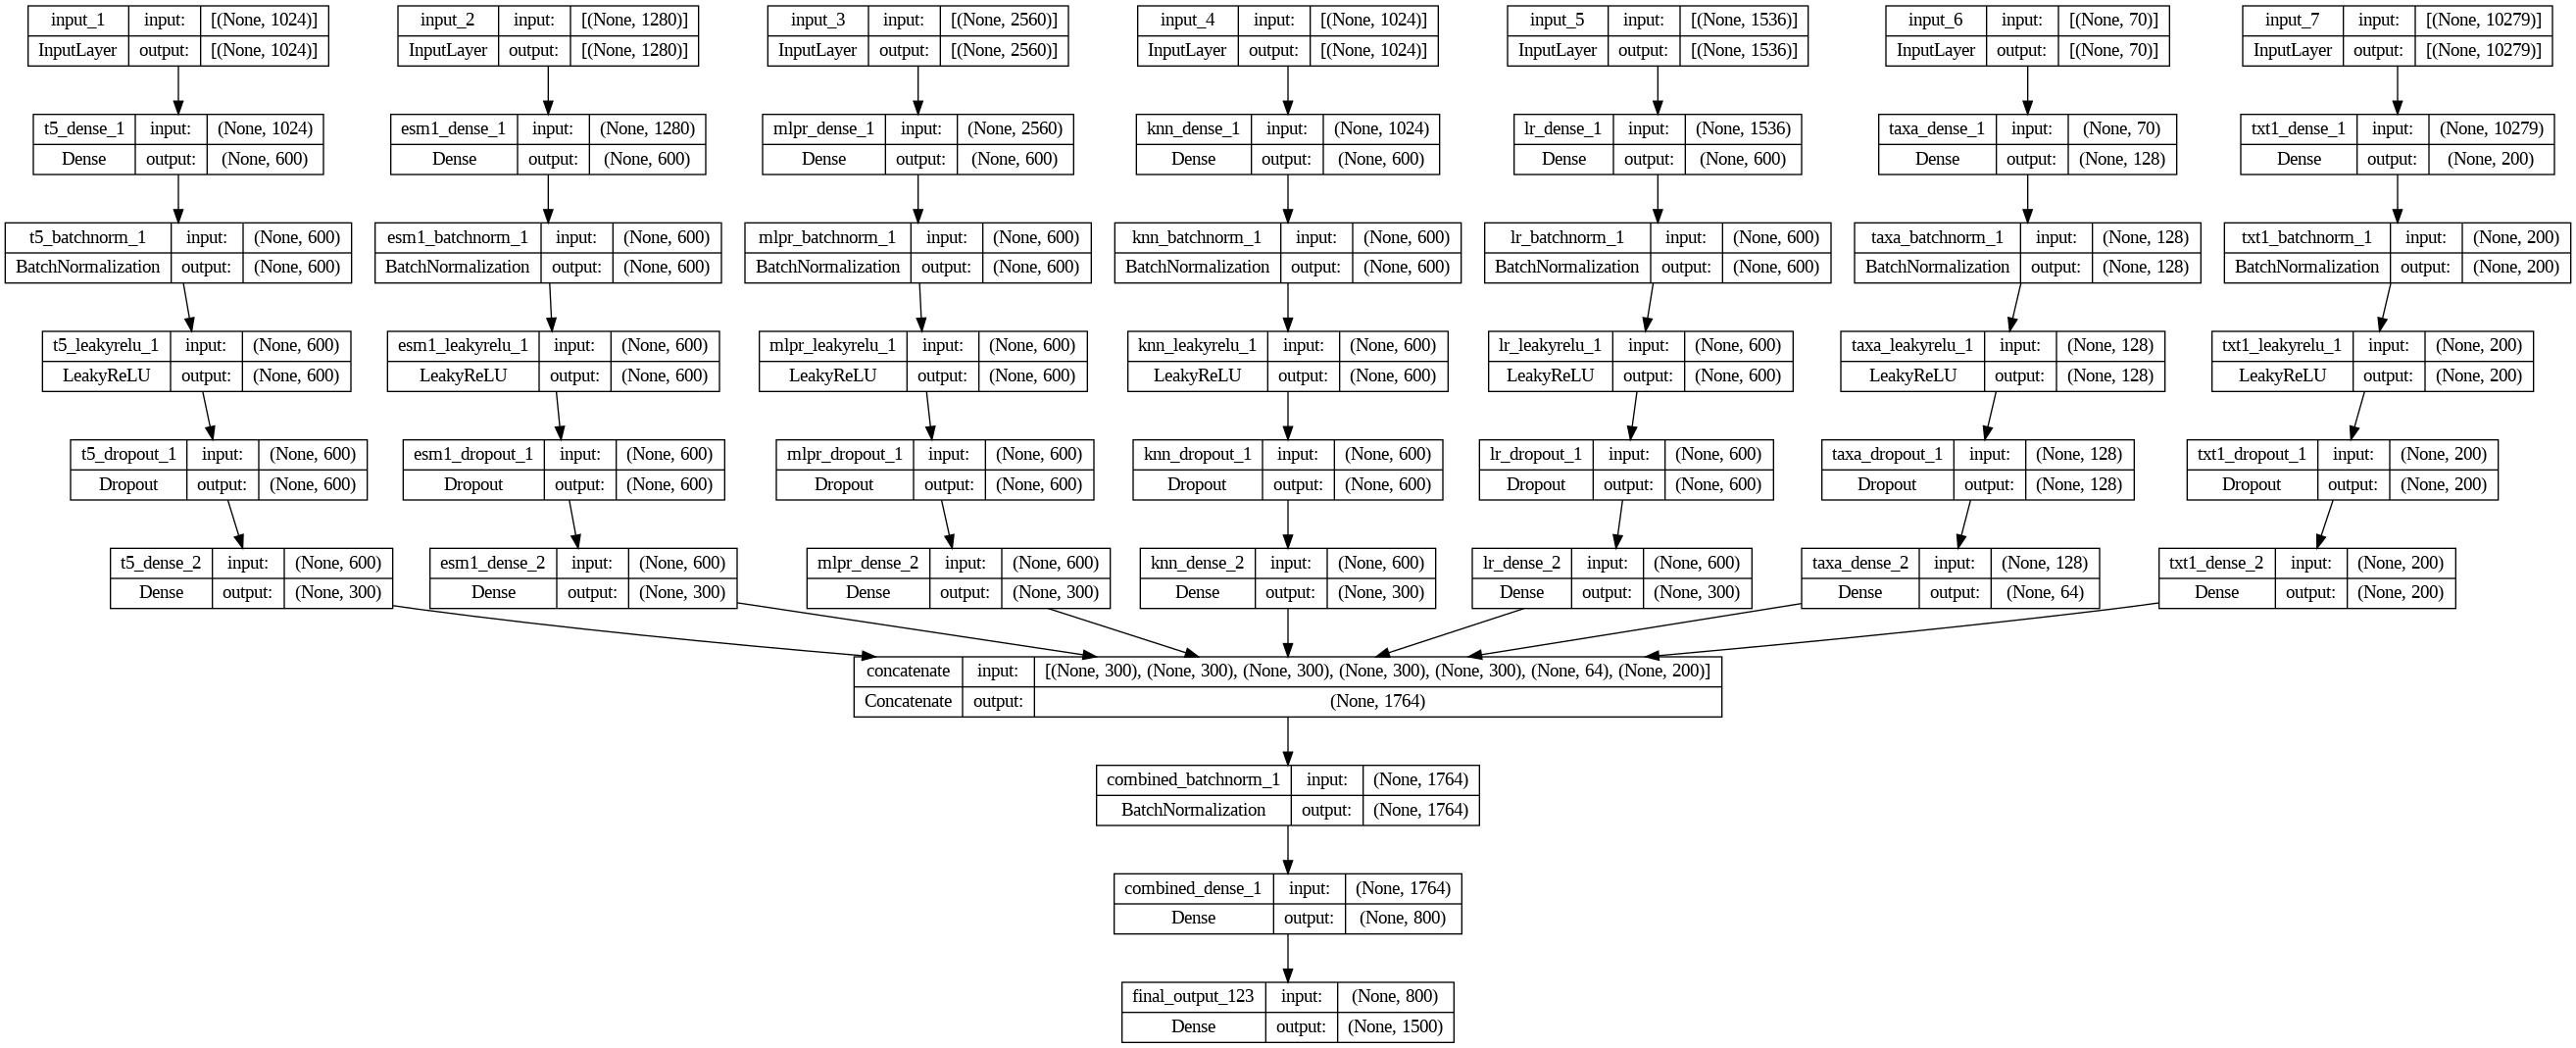

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
ontology = 'BPO'
version_no = 'f02'
fold_ct = 1
rand_state_no = 1

model_path = f'/content/drive/MyDrive/CAFA5 2023/1.30/{version_no}_{ontology}_fc{fold_ct}_r{rand_state_no}.hdf5'
model = load_model(model_path)

# Plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
# For submission for CAFA test set
test_labels = np.load('/content/drive/MyDrive/CAFA5 2023/Test_data/t5_labels_sorted.npy')
rand_state_nos = [1,2,3,4,5]

predictions = []

for rand_state_no in rand_state_nos:

    for fold_ct in [1,2,3,4,5]:

        model_path = f'/content/drive/MyDrive/CAFA5 2023/1.30/{version_no}_{ontology}_fc{fold_ct}_r{rand_state_no}.hdf5'
        model = load_model(model_path)

        predicted_outputs = model.predict([t5_test, esm1_test, esm2_test, pb_test, ankh_test, taxa_test, txt1_test])

        predictions.append(predicted_outputs)

        K.clear_session()
        gc.collect()

average_predictions = np.mean(predictions, axis=0)
print('average predictions shape:', average_predictions.shape)

prediction_preparation = PredictionPreparation(average_predictions, Y_labels, test_labels)
prediction_preparation.prepare_submission(filename=f"/content/drive/MyDrive/CAFA5 2023/1.30/{version_no}_{ontology}_m25.tsv", top_percent=0.05)


4434/4434 [==============================] - 14s 3ms/step
average predictions shape: (141864, 1500)
zeros dropped for 0 rows
        Protein Id  GO Term Id  Prediction
2763223     A2AWT3  GO:0071704         1.0
2763001     A2AWT3  GO:0008152         1.0
2763081     A2AWT3  GO:0044238         1.0
2763054     A2AWT3  GO:0006807         1.0
2763045     A2AWT3  GO:0043170         1.0
count    1.063980e+07
mean     2.634090e-01
std      2.573782e-01
min      5.100000e-02
25%      8.000000e-02
50%      1.460000e-01
75%      3.510000e-01
max      1.000000e+00
Name: Prediction, dtype: float64


In [ ]:
#merge ontololgy tsv submissions

# Specify the file paths of the TSV files you want to concatenate
file_paths = ['/content/drive/MyDrive/CAFA5 2023/1.30/f02_BPO_m25.tsv', '/content/drive/MyDrive/CAFA5 2023/1.30/f02_CCO_m25.tsv', '/content/drive/MyDrive/CAFA5 2023/1.30/f02_MFO_m25.tsv']

# Read the first TSV file with header, as it contains the column names
dfs = [pd.read_csv(file_paths[0], sep='\t', header=None)]

# Read the remaining TSV files without header, as they are already in the first file
for file_path in file_paths[1:]:
    dfs.append(pd.read_csv(file_path, sep='\t', header=None))

# Concatenate the DataFrames
concatenated_df = pd.concat(dfs, ignore_index=True)

# Save the concatenated DataFrame to a new TSV file
concatenated_df.to_csv('/content/drive/MyDrive/CAFA5 2023/1.30/All_test_submission_1.30.1.tsv', sep='\t', index=False)



In [ ]:
# Load the TSV file
file_path = '/content/drive/MyDrive/CAFA5 2023/1.30/All_test_submission_1.30.1.tsv'  # Replace with your file path
data = pd.read_csv(file_path, sep='\t')  # sep='\t' specifies that the file is tab-separated

# Sort the data by the first column
sorted_data = data.sort_values(by=data.columns[0])

# Display the sorted data
print(sorted_data)


                   0           1      2
4269005   A0A023PXA5  GO:0051171  0.197
6220029   A0A023PXA5  GO:0048646  0.116
20894650  A0A023PXA5  GO:0042802  0.007
17875864  A0A023PXA5  GO:0016740  0.057
4504333   A0A023PXA5  GO:0051128  0.183
...              ...         ...    ...
7989872       X6R8R1  GO:1901360  0.080
6343985       X6R8R1  GO:0048468  0.113
11411696      X6R8R1  GO:0005622  0.704
9810530       X6R8R1  GO:0023057  0.058
15017763      X6R8R1  GO:0031965  0.013

[21988920 rows x 3 columns]


In [ ]:
#print(sorted_data[sorted_data[0]=='A4IFU5'])

In [ ]:
# Sort the data by the first column
prot_P62259_sorted = prot_P62259.sort_values(by=data.columns[2])

In [ ]:
print(prot_P62259_sorted)

               0           1      2
21801248  P62259  GO:0042287  0.005
21736323  P62259  GO:0031490  0.005
21889950  P62259  GO:0070840  0.005
21895666  P62259  GO:0050998  0.005
21498605  P62259  GO:0035254  0.006
...          ...         ...    ...
264014    P62259  GO:0009987  0.956
11024275  P62259  GO:0005622  0.958
16416390  P62259  GO:0005515  0.987
16372654  P62259  GO:0005488  0.995
10757859  P62259  GO:0110165  0.998

[432 rows x 3 columns]


In [ ]:
prot_P62259_sorted.to_csv('/content/drive/MyDrive/CAFA5 2023/1.30/prot_P62259_sorted.tsv', sep='\t', index=False)

In [ ]:
sorted_data.to_csv('/content/drive/MyDrive/CAFA5 2023/1.30/f02_p_sorted.tsv', sep='\t', index=False)
